In [ ]:
import sys, subprocess, math, random, textwrap, time

def _pip_install(pkgs):
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + pkgs
    subprocess.check_call(cmd)

print("Installing dependencies (qrisp, networkx, matplotlib, sympy)...")
_pip_install(["qrisp", "networkx", "matplotlib", "sympy"])
print("✓ Installed\n")

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from qrisp import (
    QuantumVariable, QuantumFloat, QuantumChar,
    h, z, x, cx, p,
    control, QFT, multi_measurement,
    auto_uncompute
)

from qrisp.qaoa import (
    QAOAProblem, RX_mixer,
    create_maxcut_cost_operator, create_maxcut_cl_cost_function
)

from qrisp.grover import diffuser

In [ ]:
def banner(title):
    print("\n" + "="*90)
    print(title)
    print("="*90)

def topk_probs(prob_dict, k=10):
    items = sorted(prob_dict.items(), key=lambda kv: kv[1], reverse=True)[:k]
    return items

def print_topk(prob_dict, k=10, label="Top outcomes"):
    items = topk_probs(prob_dict, k=k)
    print(label)
    for state, prob in items:
        print(f"  {state}: {prob:.4f}")

def bitstring_to_partition(bitstring):
    left = [i for i, b in enumerate(bitstring) if b == "0"]
    right = [i for i, b in enumerate(bitstring) if b == "1"]
    return left, right

def classical_maxcut_cost(G, bitstring):
    s = set(i for i, b in enumerate(bitstring) if b == "0")
    cost = 0
    for u, v in G.edges():
        if (u in s) != (v in s):
            cost += 1
    return cost

banner("SECTION 1 — Qrisp Core: QuantumVariable, QuantumSession, GHZ State")

def GHZ(qv):
    h(qv[0])
    for i in range(1, qv.size):
        cx(qv[0], qv[i])

qv = QuantumVariable(5)
GHZ(qv)

print("Circuit (QuantumSession):")
print(qv.qs)

print("\nState distribution (printing QuantumVariable triggers a measurement-like dict view):")
print(qv)

meas = qv.get_measurement()
print_topk(meas, k=6, label="\nMeasured outcomes (approx.)")

qch = QuantumChar()
h(qch[0])
print("\nQuantumChar measurement sample:")
print_topk(qch.get_measurement(), k=8)

In [ ]:
banner("SECTION 2 — Grover + auto_uncompute: Solve x^2 = 0.25 (QuantumFloat oracle)")

@auto_uncompute
def sqrt_oracle(qf):
    cond = (qf * qf == 0.25)
    z(cond)

qf = QuantumFloat(3, -1, signed=True)

n = qf.size
iterations = int(0.25 * math.pi * math.sqrt((2**n) / 2))

print(f"QuantumFloat qubits: {n} | Grover iterations: {iterations}")
h(qf)

for _ in range(iterations):
    sqrt_oracle(qf)
    diffuser(qf)

print("\nGrover result distribution (QuantumFloat prints decoded values):")
print(qf)

qf_meas = qf.get_measurement()
print_topk(qf_meas, k=10, label="\nTop measured values (decoded by QuantumFloat):")

In [ ]:
banner("SECTION 3 — Quantum Phase Estimation (QPE): Controlled U + inverse QFT")

def QPE(psi: QuantumVariable, U, precision: int):
    res = QuantumFloat(precision, -precision, signed=False)
    h(res)
    for i in range(precision):
        with control(res[i]):
            for _ in range(2**i):
                U(psi)
    QFT(res, inv=True)
    return res

def U_example(psi):
    phi_1 = 0.5
    phi_2 = 0.125
    p(phi_1 * 2 * np.pi, psi[0])
    p(phi_2 * 2 * np.pi, psi[1])

psi = QuantumVariable(2)
h(psi)

res = QPE(psi, U_example, precision=3)

print("Joint measurement of (psi, phase_estimate):")
mm = multi_measurement([psi, res])
items = sorted(mm.items(), key=lambda kv: (-kv[1], str(kv[0])))
for (psi_bits, phase_val), prob in items:
    print(f"  psi={psi_bits}  phase≈{phase_val}  prob={prob:.4f}")

Installing dependencies (qrisp, networkx, matplotlib, sympy)...
✓ Installed


SECTION 1 — Qrisp Core: QuantumVariable, QuantumSession, GHZ State
Circuit (QuantumSession):
QuantumCircuit:
---------------
      ┌───┐                    
qv.0: ┤ H ├──■────■────■────■──
      └───┘┌─┴─┐  │    │    │  
qv.1: ─────┤ X ├──┼────┼────┼──
           └───┘┌─┴─┐  │    │  
qv.2: ──────────┤ X ├──┼────┼──
                └───┘┌─┴─┐  │  
qv.3: ───────────────┤ X ├──┼──
                     └───┘┌─┴─┐
qv.4: ────────────────────┤ X ├
                          └───┘
Live QuantumVariables:
----------------------
QuantumVariable qv

State distribution (printing QuantumVariable triggers a measurement-like dict view):
{'00000': 0.5, '11111': 0.5}
                                                                                     
Measured outcomes (approx.)
  00000: 0.5000
  11111: 0.5000

QuantumChar measurement sample:
Top outcomes
  a: 0.5000
  b: 0.5000

SECTION 2 — Grover + auto_uncompute: Solve x^2 =

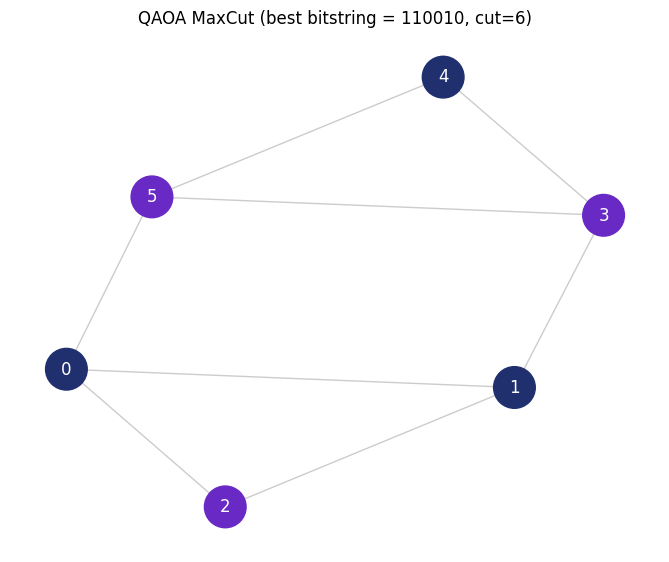


DONE — You now have Grover + QPE + QAOA workflows running in Qrisp on Colab ✅
Tip: Try increasing QAOA depth, changing the graph, or swapping mixers (RX/RY/XY) to explore behavior.


In [10]:
banner("SECTION 4 — QAOA MaxCut: QAOAProblem.run + best cut visualization")

G = nx.erdos_renyi_graph(6, 0.65, seed=133)
while G.number_of_edges() < 5:
    G = nx.erdos_renyi_graph(6, 0.65, seed=random.randint(0, 9999))

print(f"Graph: |V|={G.number_of_nodes()} |E|={G.number_of_edges()}")
print("Edges:", list(G.edges())[:12], "..." if G.number_of_edges() > 12 else "")

qarg = QuantumVariable(G.number_of_nodes())
qaoa_maxcut = QAOAProblem(
    cost_operator=create_maxcut_cost_operator(G),
    mixer=RX_mixer,
    cl_cost_function=create_maxcut_cl_cost_function(G),
)

depth = 3
max_iter = 25

t0 = time.time()
results = qaoa_maxcut.run(qarg, depth=depth, max_iter=max_iter)
t1 = time.time()

print(f"\nQAOA finished in {t1 - t0:.2f}s (depth={depth}, max_iter={max_iter})")
print("Returned measurement distribution size:", len(results))

cl_cost = create_maxcut_cl_cost_function(G)

print("\nTop 8 candidate cuts (bitstring, prob, cost):")
top8 = sorted(results.items(), key=lambda kv: kv[1], reverse=True)[:8]
for bitstr, prob in top8:
    cost_val = cl_cost({bitstr: 1})
    print(f"  {bitstr}  prob={prob:.4f}  cut_edges≈{cost_val}")

best_bitstr = top8[0][0]
best_cost = classical_maxcut_cost(G, best_bitstr)
left, right = bitstring_to_partition(best_bitstr)

print(f"\nMost likely solution: {best_bitstr}")
print(f"Partition 0-side: {left}")
print(f"Partition 1-side: {right}")
print(f"Classical crossing edges (verified): {best_cost}")

pos = nx.spring_layout(G, seed=42)
node_colors = ["#6929C4" if best_bitstr[i] == "0" else "#20306f" for i in G.nodes()]
plt.figure(figsize=(6.5, 5.2))
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=900,
    font_color="white",
    edge_color="#CCCCCC",
)
plt.title(f"QAOA MaxCut (best bitstring = {best_bitstr}, cut={best_cost})")
plt.show()

banner("DONE — You now have Grover + QPE + QAOA workflows running in Qrisp on Colab ✅")
print("Tip: Try increasing QAOA depth, changing the graph, or swapping mixers (RX/RY/XY) to explore behavior.")